In [34]:
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
import spacy
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score

tqdm.pandas()
spacy.require_gpu()


True

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
processed_directory = '../processed_data/'


In [5]:
train_df = pd.read_json('../processed_data/train.json')
test_df = pd.read_json('../processed_data/test.json')

In [6]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df


,id,text,rating,label
0,11041,The show is average. It doesn't make me laugh ...,4,-
1,5342,"Rachel, Jo, Hannah, Tina, Bradley and John are...",1,-
2,9255,"First, I should mention that I really enjoyed ...",2,-
3,7152,'Holes' was a GREAT movie. Disney made the rig...,9,+
4,11383,This is a fine musical with a timeless score b...,7,+
...,...,...,...,...
24995,2979,There really isn't much to say about this movi...,10,+
24996,9462,"Clean family oriented movie. I laughed, I crie...",9,+
24997,3995,'1408' is the latest hodge podge of cheap scar...,1,-
24998,11960,"""Scoop"" is also the name of a late-Thirties Ev...",8,+


In [7]:
test_df

,id,text,rating,label
0,0,I went and saw this movie last night after bei...,10,+
1,10000,Actor turned director Bill Paxton follows up h...,7,+
2,10001,As a recreational golfer with some knowledge o...,9,+
3,10002,"I saw this film in a sneak preview, and it is ...",8,+
4,10003,Bill Paxton has taken the true story of the 19...,8,+
...,...,...,...,...
24995,9998,I occasionally let my kids watch this garbage ...,1,-
24996,9999,When all we have anymore is pretty much realit...,1,-
24997,999,The basic genre is a thriller intercut with an...,3,-
24998,99,Four things intrigued me as to this film - fir...,3,-


In [8]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1559ac28be0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1559ac65160>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1559471e820>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1559acf70c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1559acfcf40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1559471e7b0>)]

In [37]:
def get_vectors(text, nlp):
    doc = nlp(text)
    return doc.vector

def get_features(df):
    text_list = df['text'].to_list()
    x = []
    for doc in tqdm_notebook(nlp.pipe(text_list, disable=["tagger", "parser", "lemmatizer", 'attribute_ruler', 'ner'])):
        x.append(doc.vector)
    x = pd.DataFrame(x)
    y = df['label']
    y = pd.get_dummies(y)
    return x, y

In [38]:
train_x, train_y = get_features(train_df)
test_x, test_y = get_features(test_df)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [39]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

In [27]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.098653,0.237332,-0.227549,-0.059897,0.041167,0.053954,0.041598,-0.212204,-0.030462,2.288359,...,-0.080512,0.013579,-0.020111,-0.011932,0.052879,0.042916,-0.025879,-0.042477,0.055505,0.032498
1,-0.056069,0.164208,-0.111401,-0.112217,0.082695,0.010604,0.085113,-0.160687,-0.034788,2.044537,...,-0.165167,0.016225,-0.042601,-0.053598,0.078946,0.026528,-0.003979,-0.089736,0.024499,0.031012
2,-0.025594,0.173807,-0.113592,-0.080288,0.121748,0.046220,0.017448,-0.121140,-0.023063,1.976007,...,-0.173515,0.041926,0.017024,-0.010830,0.033183,0.007571,-0.033585,-0.045075,-0.011756,0.023251
3,-0.026709,0.228059,-0.154029,-0.129077,0.087855,-0.003604,0.082640,-0.213129,-0.046223,2.200672,...,-0.098601,0.031794,-0.006471,-0.035367,0.128100,-0.073214,-0.107157,-0.002758,0.005043,0.104389
4,0.016726,0.186435,-0.135161,-0.096413,0.078521,0.070652,0.035408,-0.179566,-0.033138,1.932208,...,-0.181982,0.011574,0.040958,0.000037,0.036744,0.055756,-0.035302,-0.084084,-0.013650,0.137881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.048090,0.150734,-0.123009,-0.092647,0.115555,0.020735,0.023961,-0.114092,0.011440,1.860095,...,-0.152963,-0.000891,-0.026846,-0.014160,0.028144,0.015263,-0.062839,-0.095883,-0.006639,0.062071
24996,-0.017593,0.180526,-0.135005,-0.160613,0.102259,0.020344,0.046305,-0.236645,0.012075,2.176674,...,-0.132983,0.009750,-0.024606,-0.018269,0.093126,-0.020145,-0.034903,-0.032044,0.034915,0.105352
24997,0.001822,0.137014,-0.122286,-0.069232,0.090511,0.021604,-0.009902,-0.085119,0.006140,2.144040,...,-0.190512,0.064347,-0.009885,-0.021734,0.027786,0.033115,-0.042924,-0.037416,0.026347,0.049002
24998,-0.032313,0.183513,-0.095211,-0.022576,0.099779,0.036688,0.028060,-0.141543,-0.052280,1.960207,...,-0.123420,0.027996,0.019448,-0.013598,0.019727,0.016152,-0.016169,-0.075711,-0.018939,0.019662


In [28]:
train_y

,+,-
0,0,1
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
24995,1,0
24996,1,0
24997,0,1
24998,1,0


In [54]:
model = Sequential([
    Dense(512, input_shape=(300,), activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
callbacks=[
    ModelCheckpoint(filepath='./models/checkpoint',
                   save_best_only=True, verbose=1)
]

In [85]:
model.compile(optimizer=SGD(momentum=0.02), loss=CategoricalCrossentropy())

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=300,
         validation_split=0.3,
         callbacks=callbacks)

Epoch 1/300
128/137 [===========================>..] - ETA: 0s - loss: 0.2991
Epoch 1: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 6ms/step - loss: 0.2954 - val_loss: 0.3515
Epoch 2/300
130/137 [===========================>..] - ETA: 0s - loss: 0.2910
Epoch 2: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 4ms/step - loss: 0.2899 - val_loss: 0.3540
Epoch 3/300
135/137 [============================>.] - ETA: 0s - loss: 0.2942
Epoch 3: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 4ms/step - loss: 0.2946 - val_loss: 0.4109
Epoch 4/300
131/137 [===========================>..] - ETA: 0s - loss: 0.2827
Epoch 4: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2830 - val_loss: 0.3266
Epoch 5/300
128/137 [===========================>..] - ETA: 0s - loss: 0.2944
Epoch 5: val_loss did not improve from 0.32258
137/137 [==========

135/137 [============================>.] - ETA: 0s - loss: 0.2749
Epoch 39: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2753 - val_loss: 0.4612
Epoch 40/300
135/137 [============================>.] - ETA: 0s - loss: 0.2707
Epoch 40: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2710 - val_loss: 0.3381
Epoch 41/300
135/137 [============================>.] - ETA: 0s - loss: 0.2865
Epoch 41: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2871 - val_loss: 0.5205
Epoch 42/300
136/137 [============================>.] - ETA: 0s - loss: 0.2872
Epoch 42: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2868 - val_loss: 0.3551
Epoch 43/300
133/137 [============================>.] - ETA: 0s - loss: 0.2783
Epoch 43: val_loss did not improve from 0.32258
137/137 [=============

Epoch 77/300
134/137 [============================>.] - ETA: 0s - loss: 0.2744
Epoch 77: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2746 - val_loss: 0.3537
Epoch 78/300
133/137 [============================>.] - ETA: 0s - loss: 0.2680
Epoch 78: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2702 - val_loss: 0.3263
Epoch 79/300
134/137 [============================>.] - ETA: 0s - loss: 0.2678
Epoch 79: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2676 - val_loss: 0.3408
Epoch 80/300
135/137 [============================>.] - ETA: 0s - loss: 0.2784
Epoch 80: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2788 - val_loss: 0.3292
Epoch 81/300
134/137 [============================>.] - ETA: 0s - loss: 0.2747
Epoch 81: val_loss did not improve from 0.32258
137/137 [

Epoch 115/300
134/137 [============================>.] - ETA: 0s - loss: 0.2535
Epoch 115: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2522 - val_loss: 0.4448
Epoch 116/300
133/137 [============================>.] - ETA: 0s - loss: 0.2567
Epoch 116: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2555 - val_loss: 0.3434
Epoch 117/300
134/137 [============================>.] - ETA: 0s - loss: 0.2592
Epoch 117: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2606 - val_loss: 0.3349
Epoch 118/300
133/137 [============================>.] - ETA: 0s - loss: 0.2507
Epoch 118: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2510 - val_loss: 0.4195
Epoch 119/300
133/137 [============================>.] - ETA: 0s - loss: 0.2556
Epoch 119: val_loss did not improve from 0.32258

137/137 [==============================] - 1s 5ms/step - loss: 0.2352 - val_loss: 0.4439
Epoch 153/300
134/137 [============================>.] - ETA: 0s - loss: 0.2426
Epoch 153: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2462 - val_loss: 0.5256
Epoch 154/300
134/137 [============================>.] - ETA: 0s - loss: 0.2386
Epoch 154: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2386 - val_loss: 0.3750
Epoch 155/300
133/137 [============================>.] - ETA: 0s - loss: 0.2521
Epoch 155: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2526 - val_loss: 0.3778
Epoch 156/300
134/137 [============================>.] - ETA: 0s - loss: 0.2455
Epoch 156: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2449 - val_loss: 0.3463
Epoch 157/300
133/137 [================

133/137 [============================>.] - ETA: 0s - loss: 0.2393
Epoch 190: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2383 - val_loss: 0.3636
Epoch 191/300
133/137 [============================>.] - ETA: 0s - loss: 0.2204
Epoch 191: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2291 - val_loss: 0.6379
Epoch 192/300
134/137 [============================>.] - ETA: 0s - loss: 0.2325
Epoch 192: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2363 - val_loss: 0.6075
Epoch 193/300
133/137 [============================>.] - ETA: 0s - loss: 0.2278
Epoch 193: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2292 - val_loss: 0.4266
Epoch 194/300
134/137 [============================>.] - ETA: 0s - loss: 0.2327
Epoch 194: val_loss did not improve from 0.32258
137/137 [====

Epoch 228/300
133/137 [============================>.] - ETA: 0s - loss: 0.2217
Epoch 228: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2204 - val_loss: 0.3689
Epoch 229/300
131/137 [===========================>..] - ETA: 0s - loss: 0.2280
Epoch 229: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2300 - val_loss: 0.5210
Epoch 230/300
129/137 [===========================>..] - ETA: 0s - loss: 0.2234
Epoch 230: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2223 - val_loss: 0.3680
Epoch 231/300
131/137 [===========================>..] - ETA: 0s - loss: 0.2170
Epoch 231: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2176 - val_loss: 0.4176
Epoch 232/300
134/137 [============================>.] - ETA: 0s - loss: 0.2258
Epoch 232: val_loss did not improve from 0.32258

137/137 [==============================] - 1s 5ms/step - loss: 0.1975 - val_loss: 0.3923
Epoch 266/300
133/137 [============================>.] - ETA: 0s - loss: 0.2070
Epoch 266: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2100 - val_loss: 1.0592
Epoch 267/300
134/137 [============================>.] - ETA: 0s - loss: 0.2075
Epoch 267: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2069 - val_loss: 0.4895
Epoch 268/300
133/137 [============================>.] - ETA: 0s - loss: 0.2079
Epoch 268: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2103 - val_loss: 0.3751
Epoch 269/300
134/137 [============================>.] - ETA: 0s - loss: 0.2081
Epoch 269: val_loss did not improve from 0.32258
137/137 [==============================] - 1s 5ms/step - loss: 0.2073 - val_loss: 0.3775
Epoch 270/300
133/137 [================

In [86]:
model = load_model('./models/checkpoint')

In [87]:
def change_value(row):
    if (row == 0):
        return '+'
    elif (row == 1) :
        return '-'

def remap(y):
    res= y.argmax(axis=1)
    df = pd.DataFrame(res, columns=['Predicted'])
    df['Predicted'] = df['Predicted'].apply(change_value)
    return df

def predict_result(model, x):    
    y_pred = model.predict(x)
    return remap(y_pred)
    

In [88]:
y_pred = predict_result(model, train_x)
y_true = remap(train_y.to_numpy())

In [89]:
print(f"acc: {accuracy_score(y_pred,y_true)}")
print(f"f1: {f1_score(y_pred,y_true, average='micro')}")              

acc: 0.88728
f1: 0.88728


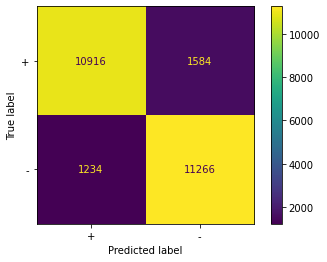

In [90]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [91]:
y_pred = predict_result(model, test_x)
y_true = remap(test_y.to_numpy())

In [92]:
print(f"acc: {accuracy_score(y_pred,y_true)}")
print(f"f1: {f1_score(y_pred,y_true, average='micro')}")              

acc: 0.855
f1: 0.855


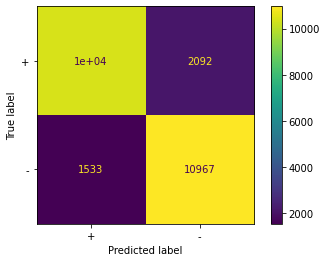

In [93]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)